<a href="https://colab.research.google.com/github/Diz138/YelpReviews/blob/main/KerasReviewToPopularity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
import nltk
from collections import Counter
import string
import re
import seaborn as sns
import tensorflow as tf
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from keras.callbacks import EarlyStopping
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
df = pd.read_pickle("/content/drive/MyDrive/CS525/yelp_food_reviews.pkl")
df.head()

,business_id,stars,useful,funny,cool,text,visits,visits_normalized,label
0,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",177.0,35.400000,1.0
3,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",204.0,18.545455,1.0
5,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,290.0,24.166667,1.0
7,LHSTtnW3YHCeUkRDGyJOyw,5.0,2,0,0,Amazingly amazing wings and homemade bleu chee...,84.0,12.000000,0.0
9,gebiRewfieSdtt17PTW6Zg,3.0,0,0,0,Had a party of 6 here for hibachi. Our waitres...,1050.0,87.500000,2.0


In [ ]:
# Sometimes we don't even get any 4 labels, use this if only going up to popularity label 3
def reduce_labels(label):
  if label > 3:
    return 3
  else:
    return label

In [ ]:
#df['label'] = df['label'].apply(
#    lamda x: reduce_labels(x)
#)

In [ ]:
subset = df[['text','label']].sample(n=100000, random_state=8)
#subset = df[['reviews_concatenated','label']]
subset.head()

,text,label
4926291,My husband & I LOVE Old Castle. It's one of ou...,1.0
6032203,"Loved it here! The food was so delicious, lite...",3.0
1243368,"Take out order for dinner with family tonight,...",1.0
2410403,Went for a simple steak dinner with a business...,1.0
5174983,Had a very disappointing experience at Trailhe...,2.0


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
subset = subset.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

# Normalize text, remove stopwords and above symbols
def clean_text(text):
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text)  
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text
subset['text'] = subset['text'].apply(clean_text)

In [ ]:
# The maximum number of words 
MAX_NB_WORDS = 50000
# Max number of words in review
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(subset['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 121460 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(subset['text'].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (100000, 250)


In [ ]:
Y = pd.get_dummies(subset['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (100000, 5)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(90000, 250) (90000, 5)
(10000, 250) (10000, 5)


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/2
1266/1266 [==============================] - 1325s 1s/step - loss: 1.2687 - accuracy: 0.4514 - val_loss: 1.2088 - val_accuracy: 0.4651
Epoch 2/2
1266/1266 [==============================] - 1318s 1s/step - loss: 1.1499 - accuracy: 0.4974 - val_loss: 1.1917 - val_accuracy: 0.4759


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

313/313 [==============================] - 22s 72ms/step - loss: 1.2032 - accuracy: 0.4719
Test set
  Loss: 1.203
  Accuracy: 0.472


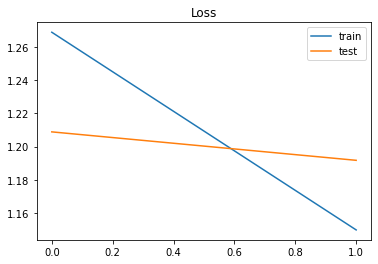

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();


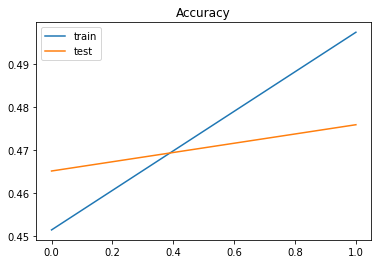

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();


In [ ]:
predicted = model.predict(X_test)

313/313 [==============================] - 23s 74ms/step


In [ ]:
predicted = np.argmax(predicted, axis=1)
Y_test = np.argmax(Y_test, axis=1)

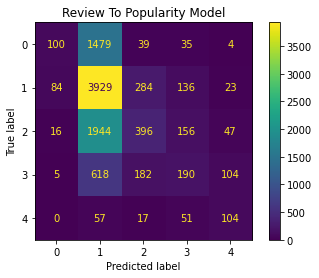

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(Y_test, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2,3,4])

cm_display.plot()
plt.title("Review To Popularity Model")
plt.show() 
